In [2]:
%load_ext autoreload
%autoreload 2

import sys; print('Python %s on %s' % (sys.version, sys.platform))

home_or_office = "home_desktop"

import sys
if home_or_office =="home_desktop":
    sys.path.extend(['C:\\Code\\Libraries', 'C:/Code/Libraries'])
elif home_or_office == "home_laptop":
    sys.path.extend(['C:\\Users\\HKGL003\\Documents\\GitHub\\Libraries'])
else:
    sys.path.extend(['C:\\Users\\troy\\Documents\\Code\\Libraries', 'C:\\Users\\troy\\Documents\\Excel Sheets', 
                     'C:/Users/troy/Documents/Code/Libraries'])


from datetime import date, datetime, timedelta
import numpy as np
import pandas as pd
import ipywidgets as widgets
import matplotlib.pyplot as plt

import dash_bootstrap_components as dbc
import plotly.express as px
from jupyter_dash import JupyterDash
from dash import dcc
from dash import html
from dash import dash_table
from dash.dependencies import Input, Output
import plotly.express as px

from tia.bbg import LocalTerminal

from FinAPI import black_lognormal, black_lognormal_vol, black_delta, black_lognormal_greek

Python 3.10.9 | packaged by Anaconda, Inc. | (main, Mar  1 2023, 18:18:15) [MSC v.1916 64 bit (AMD64)] on win32


## <font color='yellow'> Scratch for invidual download of data for Bond Future </font>

In [2]:
# First Attempt 

ticker = 'FVH14 Comdty'
option_prefix = ['FVF4', 'FVG4', 'FVH4']

fld = 'FUT_DLV_DT_FIRST'
hist_fld = 'PX_LAST'
option_flds = ['PX_LAST', 'OPEN_INT', 'PX_VOLUME']

# Get Relevant Future Data
dt = LocalTerminal.get_reference_data(ticker, fld).as_map()[ticker][fld] 
history_start = dt - timedelta(days=150)
history_end = dt
hist = LocalTerminal.get_historical(ticker, hist_fld, history_start, history_end).as_frame()
price_series = hist[(ticker, hist_fld)]

# Get the range of strikes for which we get prices
strike_spread = 0.25
strike_min = np.round(price_series.min() / strike_spread) * strike_spread
strike_max = np.round(price_series.max() / strike_spread) * strike_spread
strike_range = np.arange(strike_min-1, strike_max + 1, step=strike_spread)

# Create option tickers
option_tickers = []
ticker_dict = dict()
for pre in option_prefix:
    ticker_dict[pre] = []
    for strike in strike_range:
        option_tickers.append(pre + 'C ' + str(strike) + ' Comdty')
        option_tickers.append(pre + 'P ' + str(strike) + ' Comdty')
        ticker_dict[pre].append(pre + 'C ' + str(strike) + ' Comdty')
        ticker_dict[pre].append(pre + 'P ' + str(strike) + ' Comdty')

# Get Static Data
strike_spread = {'TU': 0.125, 'FV': 0.25, 'TY': 0.5, 'US': 1.0}

# val_per_bp = LocalTerminal.get_reference_data(ticker, "FUT_PX_VAL_BP").loc[ticker, "FUT_PX_VAL_BP"]

# Download History
option_history = LocalTerminal.get_historical(option_tickers, option_flds, history_start, history_end)
option_history_df = option_history.as_map()

# Save history

# Load History


In [3]:
# All the Futures Data
#   - Fut Price
#   - Yield
#   - Duration
#   - Conv Factor
#   - Last DLV Basket (how can we construct hitorical time series of bonds)
#   - CTD Gross Basis
#   - CTD Net Basis
#   - Implied Repo

static_fields = ['FUT_CNVS_FACTOR', 'FUT_TICK_SIZE', 'FUT_TICK_VAL', 'FUT_VAL_PT', 'LAST_TRADEABLE_DT', 'FUT_DLV_DT_FIRST', 'FUT_DLV_DT_LAST', 'FUT_FIRST_TRADE_DT']
time_series_flds = ['PX_LAST', 'FUT_CTD_GROSS_BASIS', 'FUT_CTD_NET_BASIS', 'FUT_IMPLIED_REPO_RT', 'YLD_YTM_MID', 
                    'CONVENTIONAL_CTD_FORWARD_FRSK', 'FUT_EQV_CNVX_NOTL', 'OPEN_INT', 'PX_VOLUME']
fut_ts_df = LocalTerminal.get_historical(ticker, time_series_flds, history_start, history_end).as_map()[ticker]
fut_static_dict = LocalTerminal.get_reference_data(ticker, static_fields).as_map()[ticker]

In [9]:
# Creating an Approximate Price / Yield relationship

def approx_price_yield(price, ref_price, ref_yield, dur, cvx, delta=1/32, show_iter=False):
    p = ref_price
    direction = 1 if price > ref_price else -1
    d = dur
    y = ref_yield
    if show_iter:
        print(p, y, 0, d, cvx, 0)
    while p < price:
        dpx = min(np.abs(price - p), delta)
        dyld = -1 * (-d + np.sqrt(d**2 + 2*cvx*direction*dpx))/cvx
        d = d - cvx * dyld
        p = p + direction * dpx
        y = y + dyld
        if show_iter:
            print(np.round(p,4), np.round(y,5), np.round(dpx, 5), np.round(d, 4), cvx, np.round(dyld, 6))
    return y

ref_price = 117 + 30.25 / 32
ref_yield = 1.90548
dur = 4.783
cvx = 0.23
approx_price_yield(118+16.25/32, ref_price, ref_yield, dur, cvx, show_iter=False)

1.7882066567549837

In [4]:
# Deciding the range of the strike spreads
sprd_dict = {'TU': 1.7, 'FV': 0.65, 'TY': 0.4, 'US': 0.18}
strike_spread = {'TU': 0.125, 'FV': 0.25, 'TY': 0.5, 'US': 1.0}
strike_range_bps = 50

fut_code = 'FV'
price_series = fut_ts_df['PX_LAST']
strike_min = np.round(price_series.min() / strike_spread[fut_code]) * strike_spread[fut_code]
strike_max = np.round(price_series.max() / strike_spread[fut_code]) * strike_spread[fut_code]
strike_mean = np.round(((strike_max + strike_min)/2) / strike_spread[fut_code]) * strike_spread[fut_code]

strike_rng_50 = np.ceil(strike_range_bps / sprd_dict[fut_code]) * 1/32

strike_max = max(strike_max, strike_mean + strike_rng_50)
strike_max = np.round(strike_max / strike_spread[fut_code]) * strike_spread[fut_code]
strike_min = min(strike_min, strike_mean - strike_rng_50)
strike_min = np.round(strike_min / strike_spread[fut_code]) * strike_spread[fut_code]

strike_range = np.arange(strike_min, strike_max + sprd_dict[fut_code], step=strike_spread[fut_code])

strike_min, strike_max, strike_mean, strike_range

(121.5,
 126.5,
 124.0,
 array([121.5 , 121.75, 122.  , 122.25, 122.5 , 122.75, 123.  , 123.25,
        123.5 , 123.75, 124.  , 124.25, 124.5 , 124.75, 125.  , 125.25,
        125.5 , 125.75, 126.  , 126.25, 126.5 , 126.75, 127.  ]))

In [5]:
# Create option tickes from strike range

option_tickers = []
ticker_dict = dict()
for pre in option_prefix:
    ticker_dict[pre] = []
    for strike in strike_range:
        option_tickers.append(pre + 'C ' + str(strike) + ' Comdty')
        option_tickers.append(pre + 'P ' + str(strike) + ' Comdty')
        ticker_dict[pre].append(pre + 'C ' + str(strike) + ' Comdty')
        ticker_dict[pre].append(pre + 'P ' + str(strike) + ' Comdty')

In [6]:
# Data for one option ticker

opt_ticker = option_tickers[0]
time_series_opt_flds  = ['PX_LAST','OPEN_INT', 'PX_VOLUME', ]
static_opt_flds = ['LAST_TRADEABLE_DT', 'OPT_FIRST_TRADE_DT', 'OPT_STRIKE_PX', 'OPT_SPACE_MEDIUM', 'OPT_SPACE_LOW', 'OPT_PUT_CALL', 'OPT_UNDL_TICKER']
opt_static_df = LocalTerminal.get_reference_data(opt_ticker, static_opt_flds).as_map()

opt_history_start = opt_static_df[opt_ticker]['OPT_FIRST_TRADE_DT']
opt_history_end = opt_static_df[opt_ticker]['LAST_TRADEABLE_DT']
opt_ts_df = LocalTerminal.get_historical(opt_ticker, time_series_opt_flds, opt_history_start, opt_history_end).as_map()[opt_ticker]

In [7]:
# Download IR Data
IR_TICKERS = ['USSO1Z Curncy', 'USSO2Z Curncy', 'USSO3Z Curncy', 'USSOA Curncy', 'USSOC Curncy', 'USSOF Curncy', 'USSO1 Curncy']
IR_TENORS_DAYS = [7, 14, 21, 30, 90, 180, 365]
resp = LocalTerminal.get_historical(IR_TICKERS, "PX_LAST", fut_static_dict['FUT_FIRST_TRADE_DT'], fut_static_dict['LAST_TRADEABLE_DT']).as_frame()
resp.columns = IR_TENORS_DAYS
ir_df = resp

In [9]:
# Parse functional parameters from BBG ticker

opt_ticker = "FVV2P 122.0 Comdty"
def parse_opt_ticker(tckr):
    parts = tckr.split()
    strike = float(parts[1])
    fut_code = parts[0][:2]
    typ_code = parts[0][-1]
    exp_code = parts[0][2:4]
    return dict(strike=strike, fut_code=fut_code, typ_code=typ_code, exp_code=exp_code)

In [10]:
# Download Option tickers

exhaustive_tickers = []
static_tickers = []
for k in ticker_dict:
    tickers = ticker_dict[k]
    exhaustive_tickers = exhaustive_tickers + tickers
    static_tickers = static_tickers + [tickers[int(len(tickers)/2)]]

# Download
exp_static_data = LocalTerminal.get_reference_data(static_tickers, static_opt_flds).as_map()
exp_static_data = {k.split()[0][2:4]: exp_static_data[k] for k in exp_static_data}
exp_static_df = pd.DataFrame(exp_static_data).T

# Merge
opt_static_data = {k : parse_opt_ticker(k) for k in exhaustive_tickers}
opt_static_df = pd.DataFrame(opt_static_data).T
opt_static_df = opt_static_df.join(exp_static_df, on='exp_code')

In [11]:
# Downloadd time series data

start_dt = min([d['OPT_FIRST_TRADE_DT'] for k, d in exp_static_data.items()])
end_dt = max([d['LAST_TRADEABLE_DT'] for k, d in exp_static_data.items()])
opt_ts_data = LocalTerminal.get_historical(exhaustive_tickers, time_series_opt_flds, start_dt, end_dt).as_frame()

opt_px_df = opt_ts_data.loc[:, (slice(None), slice('PX_LAST'))]
opt_px_df = opt_ts_data.loc[:, (slice(None), slice('OPEN_INT'))]

## <font color='yellow'> Working with the Downloaded Data </font>

In [12]:
# main variables
FUTURE_STATIC_DATA = fut_static_dict
FUTUTRE_TS_DATA = fut_ts_df
STRIKES = strike_range
STRIKE_RANGE_BPS = strike_range_bps
OPT_CODES = [pre[-2:] for pre in option_prefix]
OPT_TICKERS = ticker_dict
OPT_STATIC_DATA = opt_static_df
OPT_TS_DATA = {k: opt_ts_data.loc[:, (k, slice(None))] for k in opt_ts_data.columns.get_level_values(0)}   # opt_ts_data
for k, v in OPT_TS_DATA.items():
    OPT_TS_DATA[k].columns = v.columns.droplevel(0)
IR_DF = ir_df / 100


In [13]:
# Compute Interest rate for discounting for a given dateb, and calendar days and year fraction
# IR_DF, _ = IR_DF.align(OPT_TS_DATA, join='left', axis=0, method='ffill')

def extract_ir_rate(val_dt, tenor_in_days):
    # val_dt ensure datetime
    val_dt = pd.to_datetime(val_dt)
    # Val_dt not in IR_DF index
    if val_dt not in IR_DF.index:
        idx = IR_DF.index.get_loc(dt, method='nearest')
        val_dt = IR_DF.index[idx]
    # get snapshort
    rates = IR_DF.loc[val_dt, :].values
    tenors = IR_DF.columns.values
    if tenor_in_days < tenors[0]:
        return rates[0]
    elif tenor_in_days > tenors[-1]:
        return rates[-1]
    else:
        return np.interp(tenor_in_days, tenors, rates)

def compute_actact_yearfrac(val_dt, exp_dt):
    val_dt = pd.to_datetime(val_dt)
    exp_dt = pd.to_datetime(exp_dt)
    cal_days_to_expiry = (exp_dt.date() - val_dt.date()).days
    if exp_dt.date().year % 4 == 0:
        # we are in leap year
        if exp_dt > pd.to_datetime(date(exp_dt.date().year, 2, 29)):
            actact_daycount = cal_days_to_expiry / 366
        else:
            actact_daycount = cal_days_to_expiry / 365
    else:
        actact_daycount = cal_days_to_expiry / 365
    return actact_daycount

def compute_days_to_expiry(val_dt, exp_dt):
    act_days = (pd.to_datetime(exp_dt).date() - pd.to_datetime(val_dt).date()).days
    return act_days

def flip_opt_type(opt_ticker):
    parts = opt_ticker.split()
    typ = parts[0][-1]
    parts[0] = "%s%s"% (parts[0][:-1], "P" if typ=="C" else "C")
    new_ticker = ' '.join(parts)
    return new_ticker

def change_strike(opt_ticker, new_strike):
    parts = opt_ticker.split()
    new_ticker = "%s %s %s"% (parts[0], new_strike, parts[2])
    return new_ticker

def is_put(opt_ticker):
    parse_dict = parse_opt_ticker(opt_ticker)
    return parse_dict['typ_code'].upper() == "P"

def compute_impvol_fwd_greeks(opt_ticker):
    # Get time series
    px_ts = OPT_TS_DATA[opt_ticker]["PX_LAST"]
    exp_dt = OPT_STATIC_DATA.loc[opt_ticker, :]['LAST_TRADEABLE_DT']

    # Compute the year frac and interest rate and discounting factors.
    days = dict()
    yf = dict()
    ir = dict()
    for dt in px_ts.index:
        days_to_expiry = compute_days_to_expiry(dt, exp_dt=exp_dt) if dt <= exp_dt else float('nan')
        year_frac = compute_actact_yearfrac(dt, exp_dt) if dt < exp_dt else float('nan')
        ir_rate = extract_ir_rate(dt, days_to_expiry) if not np.isnan(days_to_expiry) else float('nan')
        days[dt] = days_to_expiry
        yf[dt]= year_frac
        ir[dt]= ir_rate
    df = OPT_TS_DATA[opt_ticker]
    df = df.assign(IR_RATE=pd.Series(ir))
    df = df.assign(YEAR_FRAC=pd.Series(yf))
    df = df.assign(DAYS_TO_EXP=pd.Series(days))
    df.IR_RATE = df.IR_RATE.fillna(method='ffill')
    df = df.assign(DF=1/(1 + df.YEAR_FRAC * df.IR_RATE))

    flip_df = OPT_TS_DATA[flip_opt_type(opt_ticker=opt_ticker)]

    # Compute the implied forward from Put call-parity
    k = opt_dict['strike']
    if is_put(opt_ticker):
        F = k + flip_df['PX_LAST'] - df['PX_LAST']
    else:
        F = k - (flip_df['PX_LAST'] - df['PX_LAST'])  # F is a pd.Series with datetime index

    # Compute the implied vol and risk params for the options on each date
    imp_vol = dict()
    delta = dict()
    gamma = dict()
    vega = dict()
    theta = dict()
    prev_vol = 0
    for dt in df.index:
        data_series = df.loc[dt, :]
        px = data_series['PX_LAST']
        yf = data_series['YEAR_FRAC']
        discfact = data_series['DF']
        fwd = F[dt]
        if ~np.isnan(px):
            imp_vol[dt] = black_lognormal_vol(px, fwd, opt_dict['strike'], opt_dict['typ_code'], yf, discfact)
            prev_vol = imp_vol[dt]
        elif yf==0:
            imp_vol[dt] = prev_vol if ~np.isnan(prev_vol) else float('nan')
        else:
            imp_vol[dt] = float('nan')
            prev_vol = imp_vol[dt]
        greeks = black_lognormal_greek("ALL", fwd, opt_dict['strike'], opt_dict['typ_code'], imp_vol[dt], yf, discfact)
        if isinstance(greeks, dict):
            delta[dt] = greeks['delta']
            gamma[dt] = greeks['gamma']
            vega[dt] = greeks['vega']
            theta[dt] = greeks['theta']
        else:
            print(greeks, fwd, opt_dict['strike'], opt_dict['typ_code'], imp_vol[dt], yf, discfact)
            delta[dt] = float('nan')
            gamma[dt] = float('nan')
            vega[dt] = float('nan')
            theta[dt] = float('nan')

    df = df.assign(IMP_FWD=F)
    df = df.assign(IVOL=pd.Series(imp_vol))
    df = df.assign(DELTA = pd.Series(delta))
    df = df.assign(GAMMA = pd.Series(gamma))
    df = df.assign(VEGA = pd.Series(vega))
    df = df.assign(THETA = pd.Series(theta))
    return df

def compute_impvol_fwd_greeks2(opt_ticker, debug=False):
    opt_dict = parse_opt_ticker(opt_ticker)
    flip_ticker = flip_opt_type(opt_ticker=opt_ticker)
    put_ticker, call_ticker = (opt_ticker, flip_ticker) if is_put(opt_ticker) else (flip_ticker, opt_ticker)
    k = opt_dict['strike']

    # Get time series
    put_df = OPT_TS_DATA[put_ticker]
    call_df = OPT_TS_DATA[call_ticker]
    exp_dt = OPT_STATIC_DATA.loc[opt_ticker, :]['LAST_TRADEABLE_DT']

    # Compute the implied forward from put and call prices
    F = k + call_df['PX_LAST'] - put_df['PX_LAST']

    # Compute days to expiry, year fraction, rate and discount factor
    exp_ir_discfact_data = dict()
    for dt in put_df.index:
        days_to_expiry = compute_days_to_expiry(dt, exp_dt=exp_dt) if dt <= exp_dt else float('nan')
        year_frac = compute_actact_yearfrac(dt, exp_dt) if dt <= exp_dt else float('nan')
        ir_rate = extract_ir_rate(dt, days_to_expiry) if not np.isnan(days_to_expiry) else float('nan')
        exp_ir_discfact_data [dt] = dict(DAYS_TO_EXP=days_to_expiry, YEAR_FRAC=year_frac, IR_RATE=ir_rate, DF = 1/(1+year_frac * ir_rate))

    exp_ir_df = pd.DataFrame(exp_ir_discfact_data).T
    exp_ir_df.IR_RATE = exp_ir_df.IR_RATE.fillna(method='ffill')
    exp_ir_df.DF = 1 / ( 1 + exp_ir_df.YEAR_FRAC * exp_ir_df.IR_RATE)
    put_df = put_df.join(exp_ir_df)
    call_df = call_df.join(exp_ir_df)

    # Compute implied volatility and greeks
    call_data = dict()
    put_data = dict()
    prev_vol = 0
    for dt in put_df.index:
        put_series = put_df.loc[dt, :]
        call_series = call_df.loc[dt, :]
        call_px = call_series['PX_LAST']
        put_px = put_series['PX_LAST']

        yf = call_series['YEAR_FRAC']
        discfact = call_series['DF']
        fwd = F[dt]

        if k > fwd:
            # OTM on the call side
            px = call_px
            typ = "C"
        else:
            # OTM on the put side
            px = put_px
            typ = "P"
        
        if ~np.isnan(px):
            if yf == 0:
                print(dt, exp_dt, "setting imp_vol to nan")
                prev_vol = float('nan')
            else:
                prev_vol = black_lognormal_vol(px, fwd, k, typ, yf, discfact)
            if isinstance(prev_vol, str):
                print(dt, exp_dt, prev_vol, "ARGS:", px, fwd, k, typ, yf, discfact)
        else:
            prev_vol = float('nan')

        greeks_call = black_lognormal_greek("ALL", fwd, k, "C", prev_vol, yf, discfact)
        greeks_put = black_lognormal_greek("ALL", fwd, k, "P", prev_vol, yf, discfact)

        if isinstance(greeks_call, str):
            print(greeks_call, dt, "ALL", fwd, k, "C", prev_vol, yf, discfact)
        
        if isinstance(greeks_put, str):
            print(greeks_put, dt, "ALL", fwd, k, "C", prev_vol, yf, discfact)
            
        call_data[dt] = dict(IMP_VOL=prev_vol, 
                             DELTA=greeks_call.get('delta',float('nan')), 
                             GAMMA=greeks_call.get('gamma',float('nan')), 
                             VEGA=greeks_call.get('vega',float('nan')), 
                             THETA=greeks_call.get('theta',float('nan')))
        put_data[dt] = dict(IMP_VOL=prev_vol, 
                             DELTA=greeks_put.get('delta',float('nan')), 
                             GAMMA=greeks_put.get('gamma',float('nan')), 
                             VEGA=greeks_put.get('vega',float('nan')), 
                             THETA=greeks_put.get('theta',float('nan')))

    call_data_df = pd.DataFrame(call_data).T
    put_data_df = pd.DataFrame(put_data).T

    put_df = put_df.join(put_data_df)
    call_df = call_df.join(call_data_df)
    return {put_ticker: put_df, call_ticker: call_df}

def compute_impvol_fwd_greeks_for_all(OPT_TS_DATA):
    tickers = [k for k in OPT_TS_DATA.keys() if is_put(k)]
    for ticker in tickers:
        try:
            data = compute_impvol_fwd_greeks2(ticker)
            for k, v in data.items():
                OPT_TS_DATA[k] = v
                # run diagnostics, px not nan but imp_vol is nan
                if len(v[~np.isnan(v.PX_LAST) & np.isnan(v.IMP_VOL)]) > 0:
                    print("IMP_VOL calculation failed", ticker, " Date: ", OPT_STATIC_DATA.loc[ticker, :]['LAST_TRADEABLE_DT'])
                # run diagnostics, imp_vol is not nan but delta is nan
                if len(v[~np.isnan(v.IMP_VOL) & np.isnan(v.DELTA)]) > 0:
                    print("GREEKS calculation failed", ticker, " Date: ", OPT_STATIC_DATA.loc[ticker, :]['LAST_TRADEABLE_DT'])
        except Exception as e:
            print(ticker, e)
    return OPT_TS_DATA


(Timestamp('2012-12-21 00:00:00'),
 datetime.date(2012, 12, 1),
 20,
 0.0546448087431694)

### <font color='red'> Check individual functions </font>

##### Check expiry date calculations

In [16]:
exp_dt = OPT_STATIC_DATA[OPT_STATIC_DATA['exp_code']=="F3"]['LAST_TRADEABLE_DT'][0]
val_dt = date(2012, 12, 1)
exp_dt, val_dt, compute_days_to_expiry(val_dt, exp_dt), compute_actact_yearfrac(val_dt, exp_dt)

# Check pricing using custom black scholes


(Timestamp('2012-12-21 00:00:00'),
 datetime.date(2012, 12, 1),
 20,
 0.0546448087431694)

##### Check Custom black Scholes

In [121]:
# Examine the pricing using custom blackscholes.

exp_dt = datetime(2022, 5, 20)
dt = datetime(2022, 3, 9)

days_to_expiry = 72
year_frac = days_to_expiry/365
ir_rate = 0.358
px = 31 / 64
discfact = 1 / (1 + year_frac * ir_rate/100)
strike = 118.75
typ = "C"
fwd = 117 + 17.25/32
exp_vol = 0.0464
black_lognormal_vol(px, fwd, strike, typ, 0, discfact), compute_days_to_expiry(dt, exp_dt)

('float division by zero', 72)

##### Compute impVol and greeks for one ticker

In [14]:
# compute implied vol and other for each option
opt_tickers1 = OPT_TICKERS['FVF3']
opt_ticker = opt_tickers1[int(len(opt_tickers1)/2)]
opt_ticker = 'FVF3P 122.5 Comdty'  

opt_dict = parse_opt_ticker(opt_ticker)
flip_ticker = flip_opt_type(opt_ticker=opt_ticker)
put_ticker, call_ticker = (opt_ticker, flip_ticker) if is_put(opt_ticker) else (flip_ticker, opt_ticker)
k = opt_dict['strike']


# Get time series
put_df = OPT_TS_DATA[put_ticker]
call_df = OPT_TS_DATA[call_ticker]
exp_dt = OPT_STATIC_DATA.loc[opt_ticker, :]['LAST_TRADEABLE_DT']

F = k + call_df['PX_LAST'] - put_df['PX_LAST']

exp_ir_discfact_data = dict()
for dt in put_df.index:
    days_to_expiry = compute_days_to_expiry(dt, exp_dt=exp_dt) if dt <= exp_dt else float('nan')
    year_frac = compute_actact_yearfrac(dt, exp_dt) if dt < exp_dt else float('nan')
    ir_rate = extract_ir_rate(dt, days_to_expiry) if not np.isnan(days_to_expiry) else float('nan')
    exp_ir_discfact_data [dt] = dict(DAYS_TO_EXP=days_to_expiry, YEAR_FRAC=year_frac, IR_RATE=ir_rate, DF = 1/(1+year_frac * ir_rate))

exp_ir_df = pd.DataFrame(exp_ir_discfact_data).T
put_df = put_df.join(exp_ir_df)
call_df = call_df.join(exp_ir_df)

call_data = dict()
put_data = dict()
prev_vol = 0
for dt in put_df.index:
    put_series = put_df.loc[dt, :]
    call_series = call_df.loc[dt, :]
    call_px = call_series['PX_LAST']
    put_px = put_series['PX_LAST']

    yf = call_series['YEAR_FRAC']
    discfact = call_series['DF']
    fwd = F[dt]

    if k > fwd:
        # OTM on the call side
        px = call_px
        typ = "C"
    else:
        # OTM on the put side
        px = put_px
        typ = "P"
    
    if ~np.isnan(px):
        prev_vol = black_lognormal_vol(px, fwd, k, typ, yf, discfact)
        if isinstance(prev_vol, str):
            print(prev_vol)
    elif yf==0:
        prev_vol = prev_vol if ~np.isnan(prev_vol) else float('nan')
    else:
        prev_vol = float('nan')

    greeks_call = black_lognormal_greek("ALL", fwd, k, "C", prev_vol, yf, discfact)
    greeks_put = black_lognormal_greek("ALL", fwd, k, "P", prev_vol, yf, discfact)
    call_data[dt] = dict(IMP_VOL=prev_vol, DELTA=greeks_call['delta'], GAMMA=greeks_call['gamma'], VEGA=greeks_call['vega'], THETA=greeks_call['theta'])
    put_data[dt] = dict(IMP_VOL=prev_vol, DELTA=greeks_put['delta'], GAMMA=greeks_put['gamma'], VEGA=greeks_put['vega'], THETA=greeks_put['theta'])

call_data_df = pd.DataFrame(call_data).T
put_data_df = pd.DataFrame(put_data).T

put_df = put_df.join(put_data_df)
call_df = call_df.join(call_data_df)

put_df

C:\Users\troy\Documents\Code\Libraries\FinAPI\normal_option_pricing.py:132: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(f / K) + (sig ** 2 / 2) * t) / sig / np.sqrt(t)


,PX_LAST,OPEN_INT,PX_VOLUME,DAYS_TO_EXP,YEAR_FRAC,IR_RATE,DF,IMP_VOL,DELTA,GAMMA,VEGA,THETA
date,,,,,,,,,,,,
2011-12-30,NaN,NaN,NaN,357.0,0.975410,0.001121,0.998907,NaN,NaN,NaN,NaN,NaN
2012-01-03,NaN,NaN,NaN,353.0,0.964481,0.001117,0.998924,NaN,NaN,NaN,NaN,NaN
2012-01-04,NaN,NaN,NaN,352.0,0.961749,0.001097,0.998946,NaN,NaN,NaN,NaN,NaN
2012-01-05,NaN,NaN,NaN,351.0,0.959016,0.001065,0.998979,NaN,NaN,NaN,NaN,NaN
2012-01-06,NaN,NaN,NaN,350.0,0.956284,0.001035,0.999011,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2013-02-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Compute greeks for all

In [15]:
OPT_TS_DATA = compute_impvol_fwd_greeks_for_all(OPT_TS_DATA)


ticker = 'FVF3P 122.5 Comdty'
# data = compute_impvol_fwd_greeks2(ticker)
v = OPT_TS_DATA[ticker]
x = v[~np.isnan(v.PX_LAST) & np.isnan(v.IMP_VOL)]

print(x)
v.THETA.plot()

C:\Users\troy\Documents\Code\Libraries\FinAPI\normal_option_pricing.py:132: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(f / K) + (sig ** 2 / 2) * t) / sig / np.sqrt(t)


2013-02-22 00:00:00 2013-02-22 00:00:00 setting imp_vol to nan
IMP_VOL calculation failed FVH3P 126.0 Comdty  Date:  2013-02-22 00:00:00
GREEKS calculation failed FVH3P 126.0 Comdty  Date:  2013-02-22 00:00:00
IMP_VOL calculation failed FVH3P 126.0 Comdty  Date:  2013-02-22 00:00:00
GREEKS calculation failed FVH3P 126.0 Comdty  Date:  2013-02-22 00:00:00


C:\Users\troy\Documents\Code\Libraries\FinAPI\normal_option_pricing.py:150: RuntimeWarning: invalid value encountered in double_scalars
  r = -1 * np.log(df) / t


2012-12-21 00:00:00 2012-12-21 00:00:00 setting imp_vol to nan
IMP_VOL calculation failed FVF3P 122.5 Comdty  Date:  2012-12-21 00:00:00
GREEKS calculation failed FVF3P 122.5 Comdty  Date:  2012-12-21 00:00:00
IMP_VOL calculation failed FVF3P 122.5 Comdty  Date:  2012-12-21 00:00:00
GREEKS calculation failed FVF3P 122.5 Comdty  Date:  2012-12-21 00:00:00
2013-02-22 00:00:00 2013-02-22 00:00:00 setting imp_vol to nan
IMP_VOL calculation failed FVH3P 127.0 Comdty  Date:  2013-02-22 00:00:00
GREEKS calculation failed FVH3P 127.0 Comdty  Date:  2013-02-22 00:00:00
IMP_VOL calculation failed FVH3P 127.0 Comdty  Date:  2013-02-22 00:00:00
GREEKS calculation failed FVH3P 127.0 Comdty  Date:  2013-02-22 00:00:00
2012-12-21 00:00:00 2012-12-21 00:00:00 setting imp_vol to nan
IMP_VOL calculation failed FVF3P 124.5 Comdty  Date:  2012-12-21 00:00:00
GREEKS calculation failed FVF3P 124.5 Comdty  Date:  2012-12-21 00:00:00
IMP_VOL calculation failed FVF3P 124.5 Comdty  Date:  2012-12-21 00:00:00
GR

{'FVF3C 122.5 Comdty':             PX_LAST  OPEN_INT  PX_VOLUME  DAYS_TO_EXP  YEAR_FRAC   IR_RATE  \
 date                                                                         
 2011-12-30      NaN       NaN        NaN        357.0   0.975410  0.001428   
 2012-01-03      NaN       NaN        NaN        353.0   0.964481  0.001117   
 2012-01-04      NaN       NaN        NaN        352.0   0.961749  0.001097   
 2012-01-05      NaN       NaN        NaN        351.0   0.959016  0.001065   
 2012-01-06      NaN       NaN        NaN        350.0   0.956284  0.001035   
 ...             ...       ...        ...          ...        ...       ...   
 2013-02-15      NaN       NaN        NaN          NaN        NaN  0.001600   
 2013-02-19      NaN       NaN        NaN          NaN        NaN  0.001600   
 2013-02-20      NaN       NaN        NaN          NaN        NaN  0.001600   
 2013-02-21      NaN       NaN        NaN          NaN        NaN  0.001600   
 2013-02-22      NaN       NaN

##### Cross sectional snapshots

In [119]:
from collections import defaultdict    
import random

# Preparation for query

def _split_ts_df_to_list_of_snaps(df, field):
    surfhist = df

    # Split the DF into a nested dictionary  {data_dt: {exp_code: {strike: <field>}}
    data = dict()
    for ticker in surfhist:
        parse_dict = parse_opt_ticker(ticker)
        k = parse_dict['strike']
        exp_code = parse_dict['exp_code']
        df = surfhist[ticker]
        for dt in df.index:
            if dt not in data:
                data[dt] = defaultdict(dict)
            data[dt][exp_code][k] = df.loc[dt, field]
    
    # Convert the inner nested dict {exp_code: {strike: field}} into a dataframe, and drop the dataframe if all the values are NAN
    marked_for_del = []
    for dt in data:
        data[dt] = pd.DataFrame(data[dt])
        if np.all(np.isnan(data[dt])):
            marked_for_del.append(dt)

    for dt in marked_for_del:
        del data[dt]

    # -----------------------------------------------------------------------------------------------------------------------
    # For each of the trade dates, we now find the first and last good trading dates for each of the underlying exp_codes.
    # -----------------------------------------------------------------------------------------------------------------------
    
    # Compute how many nans in each column as a fraction of the total number of strikes
    dts = data.keys()
    num_nans = dict()
    for dt in dts:
        num_nans[dt] = (np.isnan(data[dt].sort_index())*1).sum() / len(data[dt].index)

    # if all the values are NAN, replace with NAN (technical modification to work with first/last_valid_index of pd)
    nan_df = pd.DataFrame(num_nans).T
    nan_df[nan_df==1] = float('nan')   

    # Compute the frist and last valid date for each column
    valid_dts = defaultdict(dict)
    for c in nan_df.columns:
        valid_dts[c]['min']=nan_df[c].first_valid_index()
        valid_dts[c]['max']=nan_df[c].last_valid_index()

    valid_data_dates = pd.DataFrame(valid_dts)
    valid_date_union = [dt for dt in data if valid_data_dates.loc['min', :].min() <= dt <= valid_data_dates.loc['max', :].max()]
    valid_date_union.sort()
    valid_date_intersect = [dt for dt in data if valid_data_dates.loc['min', :].max() <= dt <= valid_data_dates.loc['max', :].min()]
    valid_date_intersect.sort()
    return dict(data=data, 
                valid_dates=valid_data_dates, 
                valid_date_union=valid_date_union, 
                valid_date_intersection=valid_date_intersect)
    

def split_histsurf_into_list_of_snaps(surfhist):
    data = {c: _split_ts_df_to_list_of_snaps(surfhist, c) for c in surfhist[ticker].columns}
    return data

# Some helper functions for explorations
#  --- first common valid date
#  --- random trading date
#  --- any invalid trading date

def random_valid_date(split_data, field):
    data = split_data[field]
    return random.choice(data['valid_date_union'])

def nth_valid_date(split_data, field, index=0):
    data = split_data[field]
    return data['valid_date_union'][index]

def random_common_valid_date(split_data, field):
    data = split_data[field]
    return random.choice(data['valid_date_intersection'])

def nth_common_valid_date(split_data, field, index=0):
    data = split_data[field]
    return data['valid_date_intersection'][index]

def is_valid_date(trade_dt, split_data, field):
    data = split_data[field]
    trade_dt = pd.to_datetime(trade_dt)
    return trade_dt in data['valid_date_union']

def is_valid_common_date(trade_dt, split_data, field):
    data = split_data[field]
    trade_dt = pd.to_datetime(trade_dt)
    return trade_dt in data['valid_date_intersection']

# SNAP Function
def get_snap(split_data, dt, field):
    dt = pd.to_datetime(dt)
    snap = split_data[field]['data'][dt].sort_index()
    return snap

# DATE TIME and IR FIELDS
def get_datetime_df(split_data):
    flds = ['YEAR_FRAC', 'DAYS_TO_EXP', 'IR_RATE', 'DF']
    dates_snap = pd.DataFrame({c: split_data[c]['data'][dt].iloc[0, :] for c in flds})
    return dates_snap

# Get future price

def get_fut_px(dt, FUTUTRE_TS_DATA):
    dt = pd.to_datetime(dt)
    if dt in FUTUTRE_TS_DATA.index:
        return FUTUTRE_TS_DATA.loc[dt, "PX_LAST"]
    else:
        idx = FUTUTRE_TS_DATA.index.get_loc(dt)
        if FUTURE_STATIC_DATA.index[idx] < dt:
            return FUTUTRE_TS_DATA.iloc[idx, "PX_LAST"]
        else:
            return FUTUTRE_TS_DATA.iloc[idx - 1, "PX_LAST"]

# Basic Data
surfhist = OPT_TS_DATA
split_data = split_histsurf_into_list_of_snaps(surfhist)

# Test
print(random_valid_date(split_data, "IMP_VOL"), random_common_valid_date(split_data, "IMP_VOL"), nth_valid_date(split_data, "IMP_VOL", 0), \
    nth_common_valid_date(split_data, "IMP_VOL", 0), is_valid_common_date(datetime(2012, 6, 27), split_data, "IMP_VOL"), \
        is_valid_date(datetime(2012, 6, 27), split_data, "IMP_VOL"))
        


2012-08-10 00:00:00 2012-11-09 00:00:00 2011-12-30 00:00:00 2012-10-26 00:00:00 False True


Snap date:  2012-11-29 00:00:00


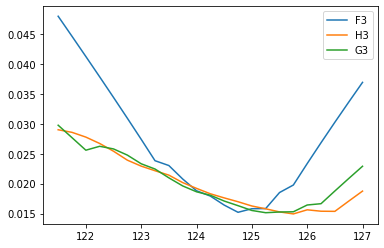

In [122]:
# SNAP TEST
dt = random_common_valid_date(split_data, "IMP_VOL")
field = "IMP_VOL"
print("Snap date: ", dt) 
get_snap(split_data, dt, field).plot()
vol_snap = get_snap(split_data, dt, field)
fut_px = get_fut_px(dt, FUTUTRE_TS_DATA)
date_time_snap = get_datetime_df(split_data)


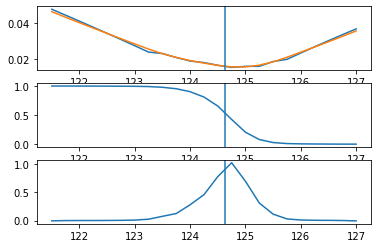

In [130]:
from FinAPI.BondFutureOption.SkewModel import SmoothingSplineLogVolSkewInterpolator

volsnap = vol_snap
objSmooth = SmoothingSplineLogVolSkewInterpolator(0.25/64, "rcv")
objSmooth.fit(np.array(volsnap.index), np.array(volsnap['F3']), fut_px, date_time_snap.loc['F3', 'DF'], date_time_snap.loc['F3', 'YEAR_FRAC'])
smooth_vols = objSmooth.sigma(np.array(volsnap.index))
plt.subplot(311)
plt.plot(volsnap.index, volsnap['F3'])
plt.plot(volsnap.index, smooth_vols)
plt.axvline(fut_px)
plt.subplot(312)
plt.plot(np.array(volsnap.index), objSmooth.call_digital(np.array(volsnap.index)))
plt.axvline(fut_px)
plt.subplot(313)
plt.plot(np.array(volsnap.index), objSmooth.density(np.array(volsnap.index)))
plt.axvline(fut_px)

In [55]:
# Create a vol surface snapshot on a given date
#   output form: {dt: Fwd , {exp_code: [K, <data>]}}   <data>: Call/Put_Price, ImpVol, Call/Put_Delta, Call/Put_Gamma, Call/Put_Theta, Call/Put_Vega, Strike_perc
#   -- Query Functionalities:
#       @ exp_code <-> exp_dt  (Done)
#       @ K <-> Delta, Vega, gamma, theta (Done)
#       @ K <-> Strike_perc          (Done)
#       @ K, ImpVol                  (Done)
#       @ log(K/F), ImpVol           (Done)
#       @ K/F, ImpVol                (Done)
#       @ is_valid_dt(dt)            (Done)
#       @ earliest_available_dt()    (Done)
#       @ interpolated_vol()            

# How to aggregate:
#       Data( . |K, exp_dt, data_dt)
#       Skew (K | exp_dt, data_dt) <-> SmoothSkew
#       Surface (K, exp_dt| data_dt)
#       SurfaceHist(K, exp_dt, data_dt)


field = "IMP_VOL"
data_dt = datetime(2012, 11, 14) # 2012-09-10

data = dict()
for ticker in OPT_TS_DATA:
    parse_dict = parse_opt_ticker(ticker)
    k = parse_dict['strike']
    exp_code = parse_dict['exp_code']
    df = OPT_TS_DATA[ticker]
    for dt in df.index:
        if dt not in data:
            data[dt] = defaultdict(dict)
        data[dt][exp_code][k] = df.loc[dt, field]

marked_for_del = []
for dt in data:
    data[dt] = pd.DataFrame(data[dt])
    if np.all(np.isnan(data[dt])):
        marked_for_del.append(dt)

for dt in marked_for_del:
    del data[dt]

dts = data.keys()
num_nans = dict()
for dt in dts:
    num_nans[dt] = (np.isnan(data[dt].sort_index())*1).sum() / len(data[dt].index)

nan_df = pd.DataFrame(num_nans).T
nan_df[nan_df==1] = float('nan')

valid_dts = defaultdict(dict)
for c in nan_df.columns:
    valid_dts[c]['min']=nan_df[c].first_valid_index()
    valid_dts[c]['miax']=nan_df[c].last_valid_index()

valid_data_dates = pd.DataFrame(valid_dts)


,F3,H3,G3
min,2012-09-21,2011-12-30,2012-10-26
miax,2012-12-20,2013-02-21,2013-01-24


##### TO DO

In [ ]:
# Compute Implied Log Vol for each option (Done)
# compute Greeks for each options (Done)
# Calibrate smooth Vol Skew ()
# store it in the OPT_TS_DATA
# compute Snapshots (Cross sectional)
# Compute Time series of Risk Factors
# Compute realized Vol (C-C, OHLC based etc., different durations)
# colection of Cross Sectional 

## <font color='Yellow' > Object encapsulated History </font>

In [198]:
from FinAPI.BondFutureOption.HistoricalSnapshot import FutVolSurfaceHistory

obj = FutVolSurfaceHistory("FV", "Z12")
obj.load_data()

174